## Goal

Here, we compare chromosome 8 of the human genome from X or Y-bearing sperm.

1) ~~Obtain eigenvector 1 (E1 track)~~
2) apply pymc model (train on data)
3) obtain confidence intervals
4) quantify differences

## Load the eigenvector tracks

In [1]:
import pandas as pd
from glob import glob
from pprint import pprint

eig_paths = glob('../data/eigs/*chr8*')
#eig_paths = glob('../data/eigs/*chr8.eigs.10000.*')
eig_paths.sort(key=lambda x: int(x.split('eigs.')[1].split('.arms')[0]), reverse=True)
eig_paths

[]

In [2]:
pd.read_csv(eig_paths[0], sep='\t', index_col=0).columns.str.lower()

Index(['start', 'end', 'weight', 'e1', 'e2', 'e3'], dtype='object')

In [3]:
from pprint import pprint

# Assuming eig_paths is a list of file paths
resolutions = [eig_path.split('eigs.')[1].split('.arms.cis')[0] for eig_path in eig_paths]
sex_chrom = [eig_path.split('_')[1].split('.')[0] for eig_path in eig_paths]

# Use zip to pair resolutions, sex_chrom, and eig_paths
eigs_dict = {}
for resolution, chrom, path in zip(resolutions, sex_chrom, eig_paths):
    if resolution not in eigs_dict:
        eigs_dict[resolution] = {}
    eigs_dict[resolution][chrom] = path

# Pretty print the resulting dictionary
pprint(eigs_dict)

{'10000': {'X': '../data/eigs/sperm_X.chr8.eigs.10000.arms.cis.vecs.tsv',
           'Y': '../data/eigs/sperm_Y.chr8.eigs.10000.arms.cis.vecs.tsv'},
 '100000': {'X': '../data/eigs/sperm_X.chr8.eigs.100000.arms.cis.vecs.tsv',
            'Y': '../data/eigs/sperm_Y.chr8.eigs.100000.arms.cis.vecs.tsv'},
 '50000': {'X': '../data/eigs/sperm_X.chr8.eigs.50000.arms.cis.vecs.tsv',
           'Y': '../data/eigs/sperm_Y.chr8.eigs.50000.arms.cis.vecs.tsv'}}


## A function to build the model from eigs_dict

In [4]:
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as pt

In [5]:

def build_model_from_config(path, cfg):
    """
    Build a PyMC model based on the provided configuration dictionary.
    """
    df = pd.read_csv(path, sep="\t")
    df.columns = df.columns.str.lower()
    df.dropna(inplace=True)
    e1 = df.e1.values 
    # mean_negative = df.e1[df.e1 < 0].mean()
    # mean_positive = df.e1[df.e1 > 0].mean()
    #cfg['mu_mu'] = np.array([mean_negative, mean_positive])
    #cfg['mu_sigma'] = np.array([df.e1[df.e1 < 0].std(), df.e1[df.e1 > 0].std()])
    
    with pm.Model(coords={"pos": df.start.values, "label": ["B", "A"]}) as model:
        # e1 = pm.Data("e1", df.e1.values, dims="pos")


        mu = pm.Normal("mu", mu=cfg['mu_mu'], sigma=cfg['mu_sigma'],
                       transform=pm.distributions.transforms.ordered, dims="label")
        sigma = pm.HalfNormal("sigma", sigma=cfg['sigma'], dims="label")

        # components: Normal or StudentT
        if cfg['comp_dist'] == "Normal":
            components = pm.Normal.dist(mu=mu, sigma=sigma, shape=2)
        else:
            components = pm.StudentT.dist(mu=mu, sigma=sigma, **cfg['comp_kwargs'], shape=2)

        # grw_sigma: HalfNormal or HalfStudentT
        if cfg['grw_sigma_dist'] == "HalfNormal":
            grw_sigma = pm.HalfNormal("grw_sigma", **cfg['grw_sigma_kwargs'])
        else:
            grw_sigma = pm.HalfStudentT("grw_sigma", **cfg['grw_sigma_kwargs'])

        # eps: Normal or StudentT
        if cfg['eps_dist'] == "Normal":
            eps = pm.Normal("eps", dims="pos", mu=0.0, sigma=1.0)
        else:
            eps = pm.StudentT("eps", dims="pos", mu=0.0, sigma=1.0, nu=cfg['eps_kwargs']['nu'])

        logit_w = pm.Deterministic("logit_w", pt.cumsum(eps*grw_sigma), dims="pos")
        w = pm.Deterministic("w", pm.math.sigmoid(logit_w), dims="pos")

        # # Latent z variable
        # z = pm.Bernoulli("z", p=w, dims="pos")


        y_hat = pm.Mixture("y_hat", w=pt.stack([1-w,w], axis=1), comp_dists=components,
                           observed=e1, dims='pos')

    return model

    

In [6]:
import json

config = {
    'name': 'N_T_HN',
    'comp_dist': 'Normal',
    'comp_kwargs': {},
    'eps_dist': 'StudentT',
    'eps_kwargs': {'nu': 10},
    'grw_sigma_dist': 'HalfNormal',
    'grw_sigma_kwargs': {'sigma': 0.075},
    'mu_mu': [-0.5, 0.5],
    'mu_sigma': 0.3,
    'sigma': 0.3}

In [7]:
# If we were to run different architectures
cfg_sname = config['name'].replace('_','')

models = {}
# But we aren't 
for res, dic in eigs_dict.items():
    for chrom, path in dic.items():
        print(f"""
res: {res} 
dicitems:
    chrom: {chrom}
    path: {path}
""")
        model_name = f"{int(res)/1000:.0f}kb.{chrom}.{cfg_sname}" # Add f".{cfg_sname}" here if needed
        models[model_name] = build_model_from_config(path, config)

print()
pprint(models)
        


res: 100000 
dicitems:
    chrom: X
    path: ../data/eigs/sperm_X.chr8.eigs.100000.arms.cis.vecs.tsv


res: 100000 
dicitems:
    chrom: Y
    path: ../data/eigs/sperm_Y.chr8.eigs.100000.arms.cis.vecs.tsv




res: 50000 
dicitems:
    chrom: Y
    path: ../data/eigs/sperm_Y.chr8.eigs.50000.arms.cis.vecs.tsv


res: 50000 
dicitems:
    chrom: X
    path: ../data/eigs/sperm_X.chr8.eigs.50000.arms.cis.vecs.tsv




res: 10000 
dicitems:
    chrom: X
    path: ../data/eigs/sperm_X.chr8.eigs.10000.arms.cis.vecs.tsv




res: 10000 
dicitems:
    chrom: Y
    path: ../data/eigs/sperm_Y.chr8.eigs.10000.arms.cis.vecs.tsv


{'100kb.X.NTHN': <pymc.model.core.Model object at 0x14c3b4896cf0>,
 '100kb.Y.NTHN': <pymc.model.core.Model object at 0x14c3b490f250>,
 '10kb.X.NTHN': <pymc.model.core.Model object at 0x14c3b4877230>,
 '10kb.Y.NTHN': <pymc.model.core.Model object at 0x14c3a13788a0>,
 '50kb.X.NTHN': <pymc.model.core.Model object at 0x14c3a13783e0>,
 '50kb.Y.NTHN': <pymc.model.core.Model object at 0x14c3b490e710>}


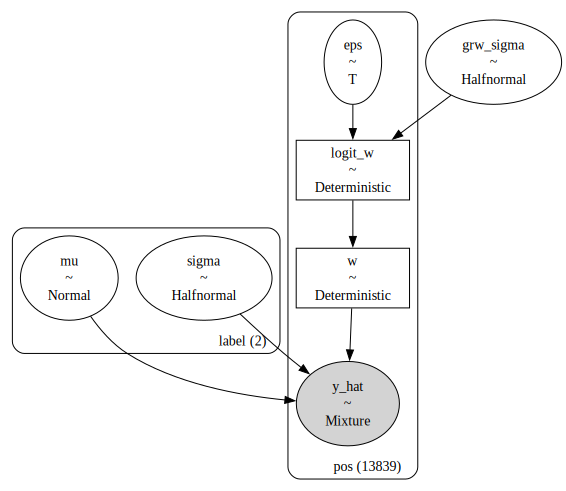

In [8]:
# # Visualize model

# from mermaid import Mermaid, Graph
# from IPython.display import Image

# mermaid = Graph('10kb_X', pm.model_to_mermaid(models['10kb.X']))
# render = Mermaid(mermaid, width=1000, height=600)

# # print(mermaid.script)
model = models['10kb.Y.NTHN']
pm.model_to_graphviz(model)




In [9]:
# Sampling loop

from datetime import datetime

def log(msg, path=".12_chr8_compare_X_Y_model.log", add_newline=False, overwrite=False):
    now = datetime.now().strftime("%Y-%m-%d %H:%M")
    msg = f"{now}: {'\n' if add_newline else ''} {msg} \n"
    print(f"[LOG] {msg}")
    if overwrite:
        with open(path, "w") as f:
            f.write(msg)
    else:
        with open(path, "a") as f:
            f.write(msg)


# Reset the log file
log("Resetting log... \n", overwrite=True)


[LOG] 2025-09-01 14:02:  Resetting log... 
 



In [10]:

for name,model in models.items():
    log(f"Sampling model: {name}")
    start = datetime.now()
    log(f"Started at {start.strftime('%H:%M:%S')}")
    with model:
        idata = pm.sample(draws=1000, tune=3000, chains=7, cores=7, progressbar=False, target_accept=0.95)
        pm.compute_log_likelihood(idata, progressbar=False)
        prior_predictive = pm.sample_prior_predictive(1000)
        posterior_predictive = pm.sample_posterior_predictive(idata, progressbar=False)
    idata.extend(prior_predictive)
    idata.extend(posterior_predictive)
    log(f"--> Took {(datetime.now()-start).total_seconds()} seconds!\n")
    save_path  = f"../results/traces/12.chr8.{name}.mix.arms.trace.nc"
    idata.to_netcdf(save_path)
    log(f"Saved model {name} to {save_path}\n")
    idata = "" 

[LOG] 2025-09-01 14:02:  Sampling model: 100kb.X.NTHN 

[LOG] 2025-09-01 14:02:  Started at 14:02:05 



Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (7 chains in 7 jobs)


NUTS: [mu, sigma, grw_sigma, eps]


Sampling 7 chains for 3_000 tune and 1_000 draw iterations (21_000 + 7_000 draws total) took 448 seconds.


Sampling: [eps, grw_sigma, mu, sigma, y_hat]


Sampling: [y_hat]


[LOG] 2025-09-01 14:10:  --> Took 481.547432 seconds!
 



Initializing NUTS using jitter+adapt_diag...


[LOG] 2025-09-01 14:10:  Saved model 100kb.X.NTHN to ../results/traces/12.chr8.100kb.X.NTHN.mix.arms.trace.nc
 

[LOG] 2025-09-01 14:10:  Sampling model: 100kb.Y.NTHN 

[LOG] 2025-09-01 14:10:  Started at 14:10:21 



Multiprocess sampling (7 chains in 7 jobs)


NUTS: [mu, sigma, grw_sigma, eps]


Sampling 7 chains for 3_000 tune and 1_000 draw iterations (21_000 + 7_000 draws total) took 242 seconds.


There were 244 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [eps, grw_sigma, mu, sigma, y_hat]


Sampling: [y_hat]


[LOG] 2025-09-01 14:14:  --> Took 271.941356 seconds!
 



Initializing NUTS using jitter+adapt_diag...


[LOG] 2025-09-01 14:15:  Saved model 100kb.Y.NTHN to ../results/traces/12.chr8.100kb.Y.NTHN.mix.arms.trace.nc
 

[LOG] 2025-09-01 14:15:  Sampling model: 50kb.Y.NTHN 

[LOG] 2025-09-01 14:15:  Started at 14:15:10 



Multiprocess sampling (7 chains in 7 jobs)


NUTS: [mu, sigma, grw_sigma, eps]


Sampling 7 chains for 3_000 tune and 1_000 draw iterations (21_000 + 7_000 draws total) took 682 seconds.


There were 2930 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [eps, grw_sigma, mu, sigma, y_hat]


Sampling: [y_hat]


[LOG] 2025-09-01 14:27:  --> Took 739.498 seconds!
 



Initializing NUTS using jitter+adapt_diag...


[LOG] 2025-09-01 14:28:  Saved model 50kb.Y.NTHN to ../results/traces/12.chr8.50kb.Y.NTHN.mix.arms.trace.nc
 

[LOG] 2025-09-01 14:28:  Sampling model: 50kb.X.NTHN 

[LOG] 2025-09-01 14:28:  Started at 14:28:04 



Multiprocess sampling (7 chains in 7 jobs)


NUTS: [mu, sigma, grw_sigma, eps]


Sampling 7 chains for 3_000 tune and 1_000 draw iterations (21_000 + 7_000 draws total) took 1470 seconds.


There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [eps, grw_sigma, mu, sigma, y_hat]


Sampling: [y_hat]


[LOG] 2025-09-01 14:53:  --> Took 1530.757157 seconds!
 



Initializing NUTS using jitter+adapt_diag...


[LOG] 2025-09-01 14:54:  Saved model 50kb.X.NTHN to ../results/traces/12.chr8.50kb.X.NTHN.mix.arms.trace.nc
 

[LOG] 2025-09-01 14:54:  Sampling model: 10kb.X.NTHN 

[LOG] 2025-09-01 14:54:  Started at 14:54:04 



Multiprocess sampling (7 chains in 7 jobs)


NUTS: [mu, sigma, grw_sigma, eps]


Sampling 7 chains for 3_000 tune and 1_000 draw iterations (21_000 + 7_000 draws total) took 6299 seconds.


There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [eps, grw_sigma, mu, sigma, y_hat]


Sampling: [y_hat]


[LOG] 2025-09-01 16:43:  --> Took 6568.470835 seconds!
 



Initializing NUTS using jitter+adapt_diag...


[LOG] 2025-09-01 16:46:  Saved model 10kb.X.NTHN to ../results/traces/12.chr8.10kb.X.NTHN.mix.arms.trace.nc
 

[LOG] 2025-09-01 16:46:  Sampling model: 10kb.Y.NTHN 

[LOG] 2025-09-01 16:46:  Started at 16:46:07 



Multiprocess sampling (7 chains in 7 jobs)


NUTS: [mu, sigma, grw_sigma, eps]


Sampling 7 chains for 3_000 tune and 1_000 draw iterations (21_000 + 7_000 draws total) took 6426 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Sampling: [eps, grw_sigma, mu, sigma, y_hat]


Sampling: [y_hat]


[LOG] 2025-09-01 18:37:  --> Took 6693.895215 seconds!
 



[LOG] 2025-09-01 18:39:  Saved model 10kb.Y.NTHN to ../results/traces/12.chr8.10kb.Y.NTHN.mix.arms.trace.nc
 



## Load back the traces

To be able to start from here

In [11]:
import arviz as az
import numpy as np

traces = {'10kb.X': az.from_netcdf(f"../results/traces/12.chr8.10kb.X.mix.arms.trace.nc"),
          '10kb.Y': az.from_netcdf(f"../results/traces/12.chr8.10kb.Y.mix.arms.trace.nc")}

traces['10kb.X']

# Or 50kb


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [12]:
display(
    az.summary(traces['10kb.X'], var_names=["mu", "sigma", "grw_sigma"]),
    az.summary(traces['10kb.Y'], var_names=["mu", "sigma", "grw_sigma"])
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[B],-0.293,0.005,-0.304,-0.283,0.0,0.0,7059.0,5762.0,1.0
mu[A],0.321,0.008,0.306,0.336,0.0,0.0,7806.0,5692.0,1.0
sigma[B],0.327,0.003,0.322,0.333,0.0,0.0,8136.0,5767.0,1.0
sigma[A],0.325,0.004,0.318,0.332,0.0,0.0,7277.0,4928.0,1.0
grw_sigma,0.080,0.003,0.075,0.086,0.0,0.0,7148.0,4999.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[B],0.006,0.165,-0.147,0.203,0.062,0.009,11.0,142.0,1.68
mu[A],0.332,0.118,0.189,0.442,0.044,0.006,11.0,142.0,1.68
sigma[B],0.328,0.010,0.310,0.341,0.003,0.001,11.0,135.0,1.65
sigma[A],0.406,0.108,0.307,0.540,0.041,0.006,11.0,150.0,1.68
grw_sigma,0.057,0.006,0.046,0.066,0.002,0.000,11.0,132.0,1.65


In [13]:
# get the w variable and stack for each model

w_vars = {name: trace.posterior.w.stack(sample=('chain', 'draw')) for name, trace in traces.items()}

for key,w in w_vars.items():
    print(f"Model: {key}")
    display(w)

Model: 10kb.X


<xarray.DataArray 'w' (pos: 13841, sample: 7000)> Size: 775MB
array([[0.55695377, 0.49817932, 0.53362606, ..., 0.51705926, 0.52172189,
        0.53474042],
       [0.54651554, 0.51556538, 0.58975761, ..., 0.48967624, 0.49194066,
        0.58102442],
       [0.56295908, 0.5494001 , 0.62182497, ..., 0.53204272, 0.53716797,
        0.56587486],
       ...,
       [0.99989203, 0.99106255, 0.9993526 , ..., 0.99807747, 0.99942434,
        0.99875594],
       [0.99988448, 0.9908002 , 0.99934231, ..., 0.99790145, 0.99936686,
        0.99878875],
       [0.99988719, 0.99125599, 0.99928624, ..., 0.99803523, 0.99937519,
        0.99867027]], shape=(13841, 7000))
Coordinates:
  * pos      (pos) int64 111kB 210000 220000 230000 ... 145050000 145060000
  * sample   (sample) object 56kB MultiIndex
  * chain    (sample) int64 56kB 0 0 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6 6 6
  * draw     (sample) int64 56kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

Model: 10kb.Y


<xarray.DataArray 'w' (pos: 13839, sample: 7000)> Size: 775MB
array([[0.53386527, 0.48957473, 0.51151567, ..., 0.52418946, 0.49115558,
        0.52374612],
       [0.54716117, 0.48886591, 0.54436929, ..., 0.5269982 , 0.49894936,
        0.52678663],
       [0.54992248, 0.52007089, 0.52004585, ..., 0.52475705, 0.51135775,
        0.52307119],
       ...,
       [0.99969409, 0.999093  , 0.99764557, ..., 0.98865389, 0.97193969,
        0.99600287],
       [0.99970848, 0.99902814, 0.99784188, ..., 0.98974823, 0.97037888,
        0.99626259],
       [0.99969688, 0.99905783, 0.99781272, ..., 0.98975501, 0.97031389,
        0.9962842 ]], shape=(13839, 7000))
Coordinates:
  * pos      (pos) int64 111kB 210000 220000 230000 ... 145050000 145060000
  * sample   (sample) object 56kB MultiIndex
  * chain    (sample) int64 56kB 0 0 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6 6 6
  * draw     (sample) int64 56kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

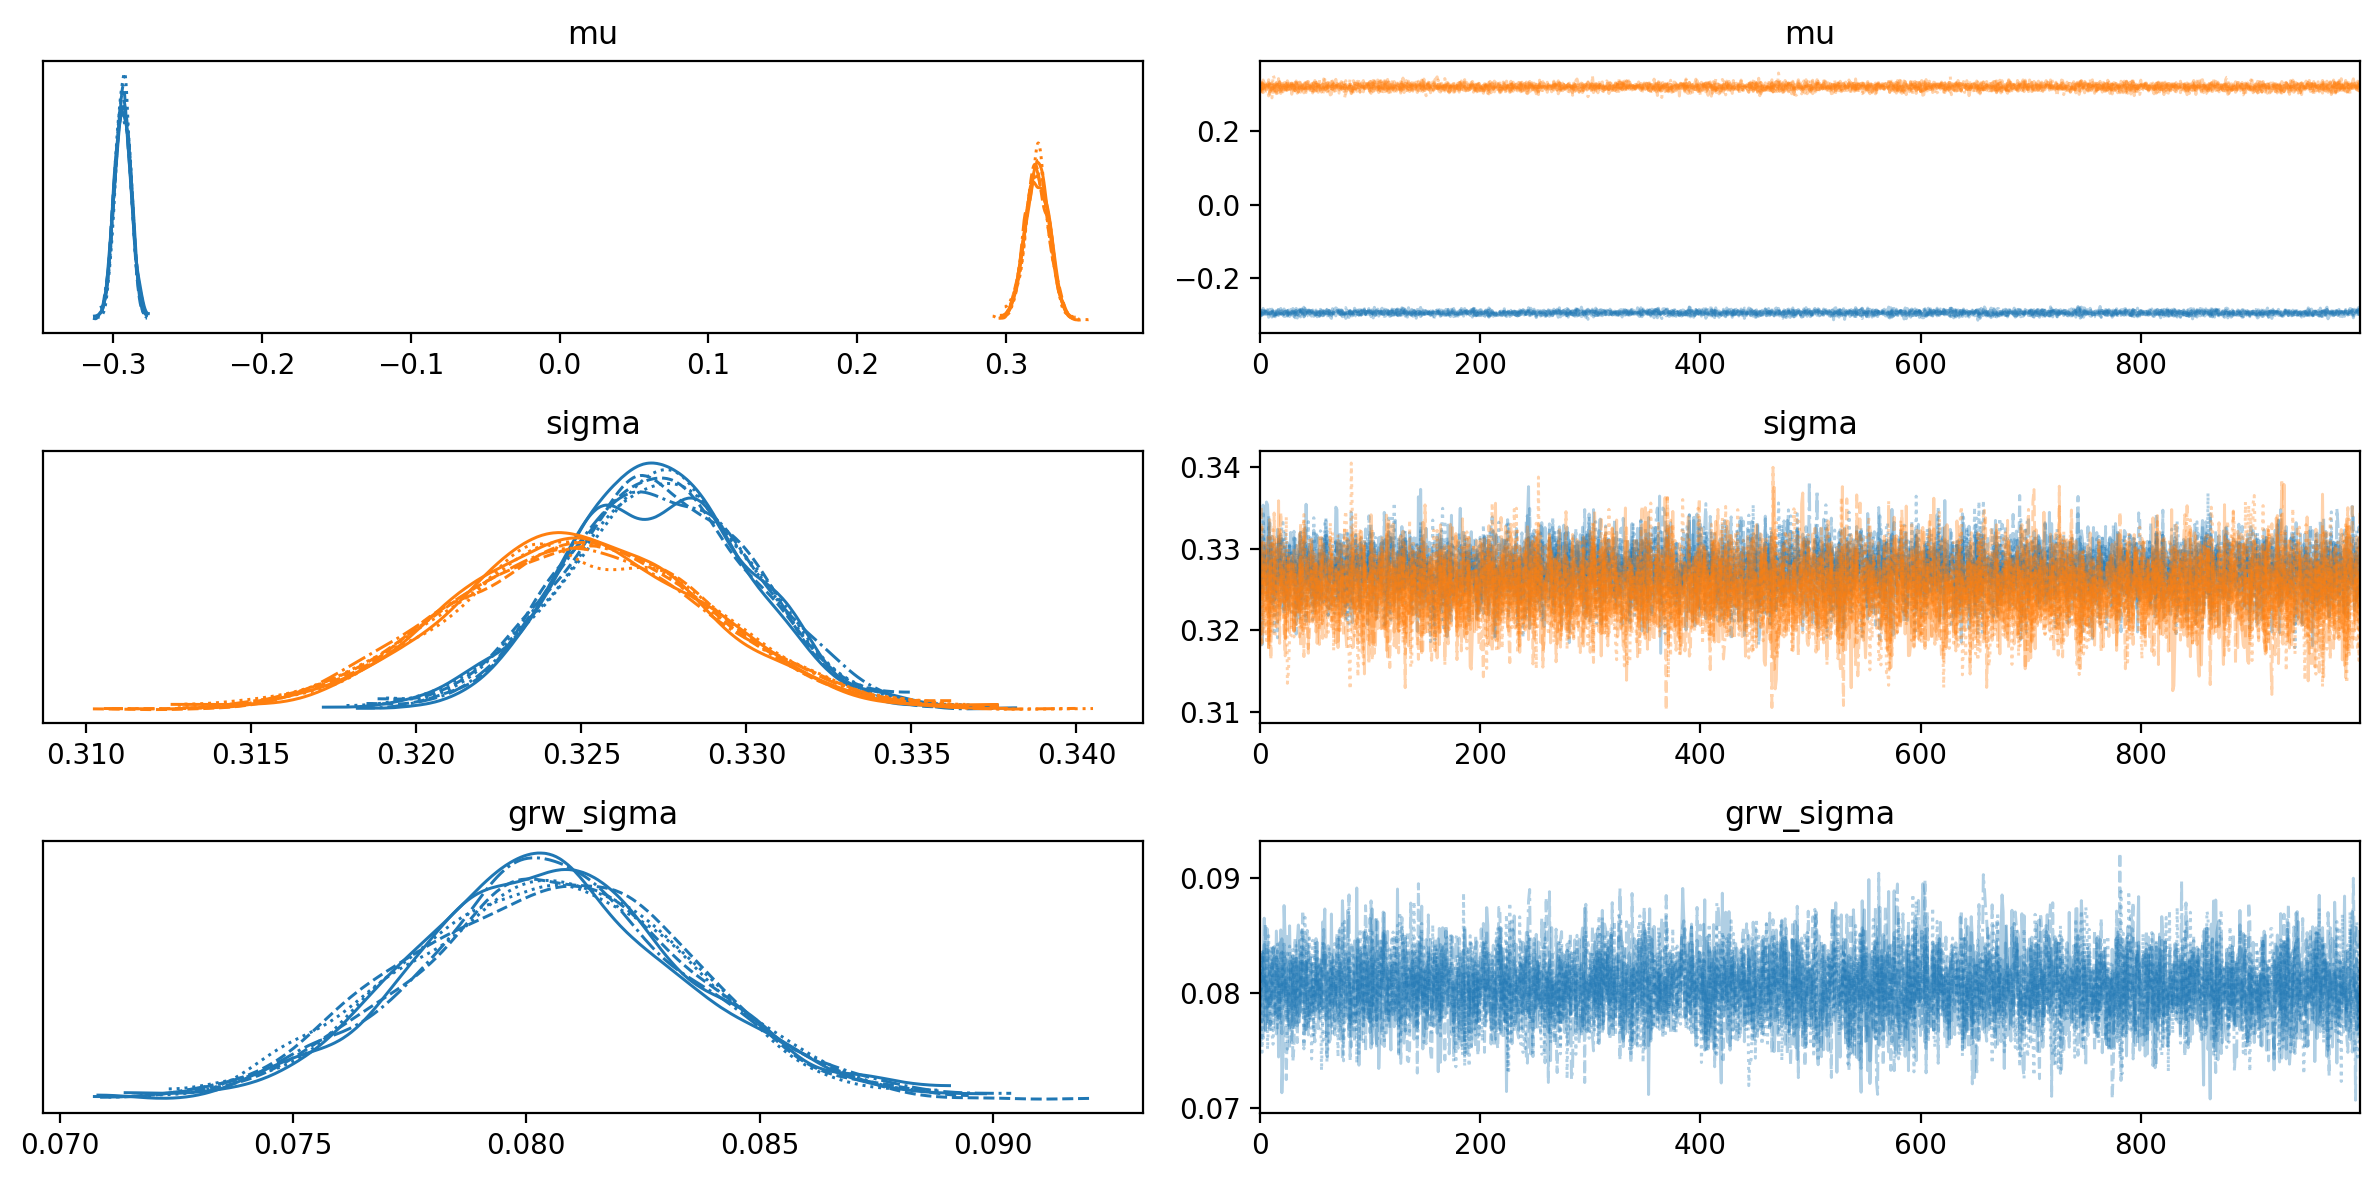

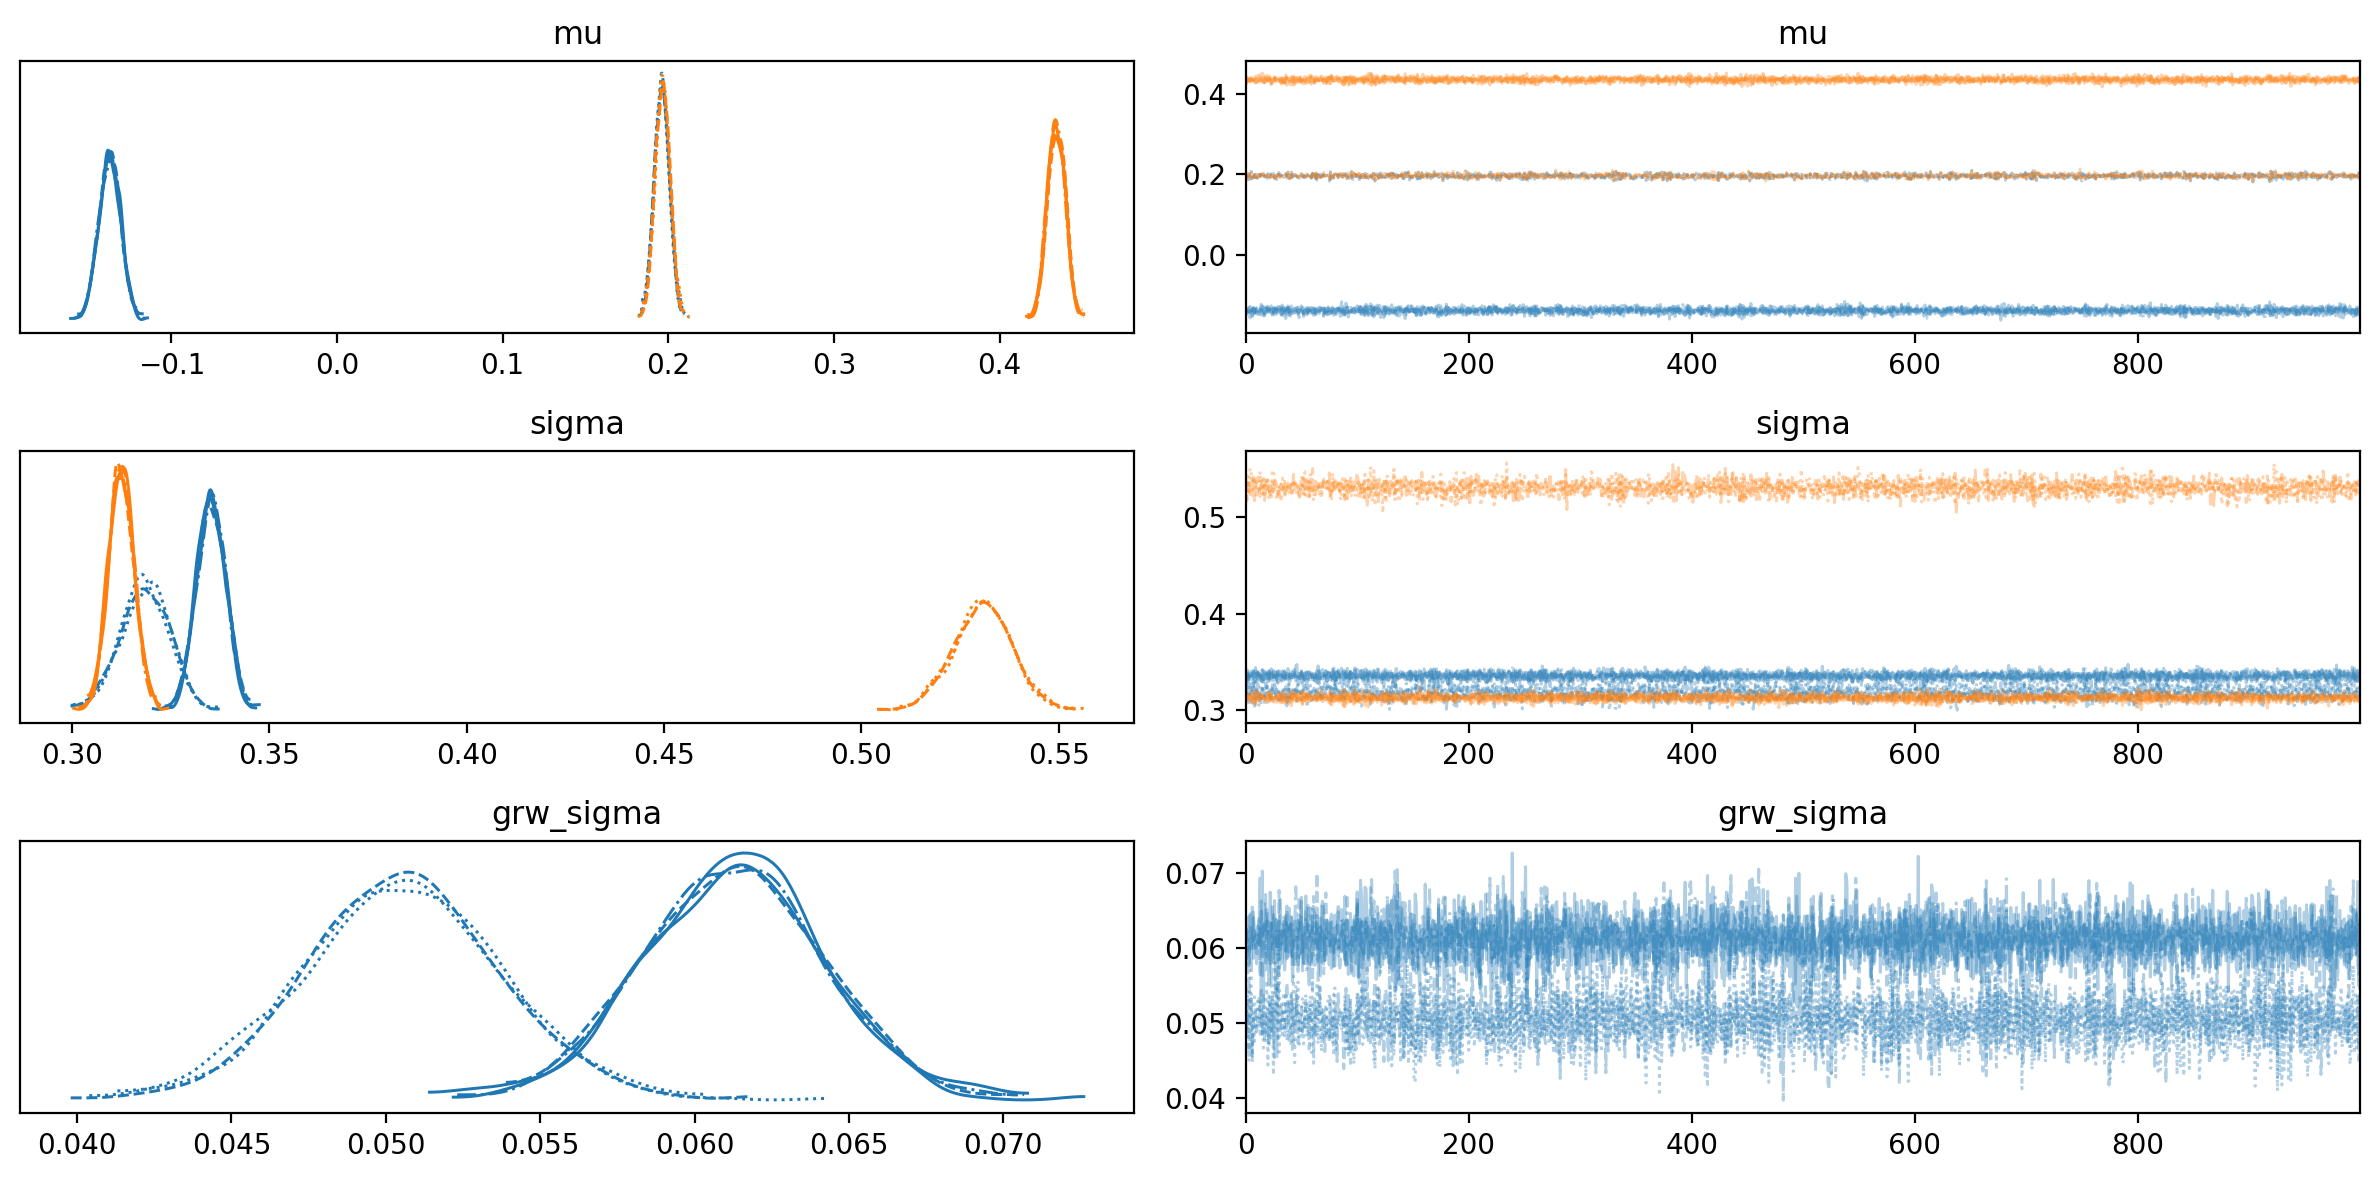

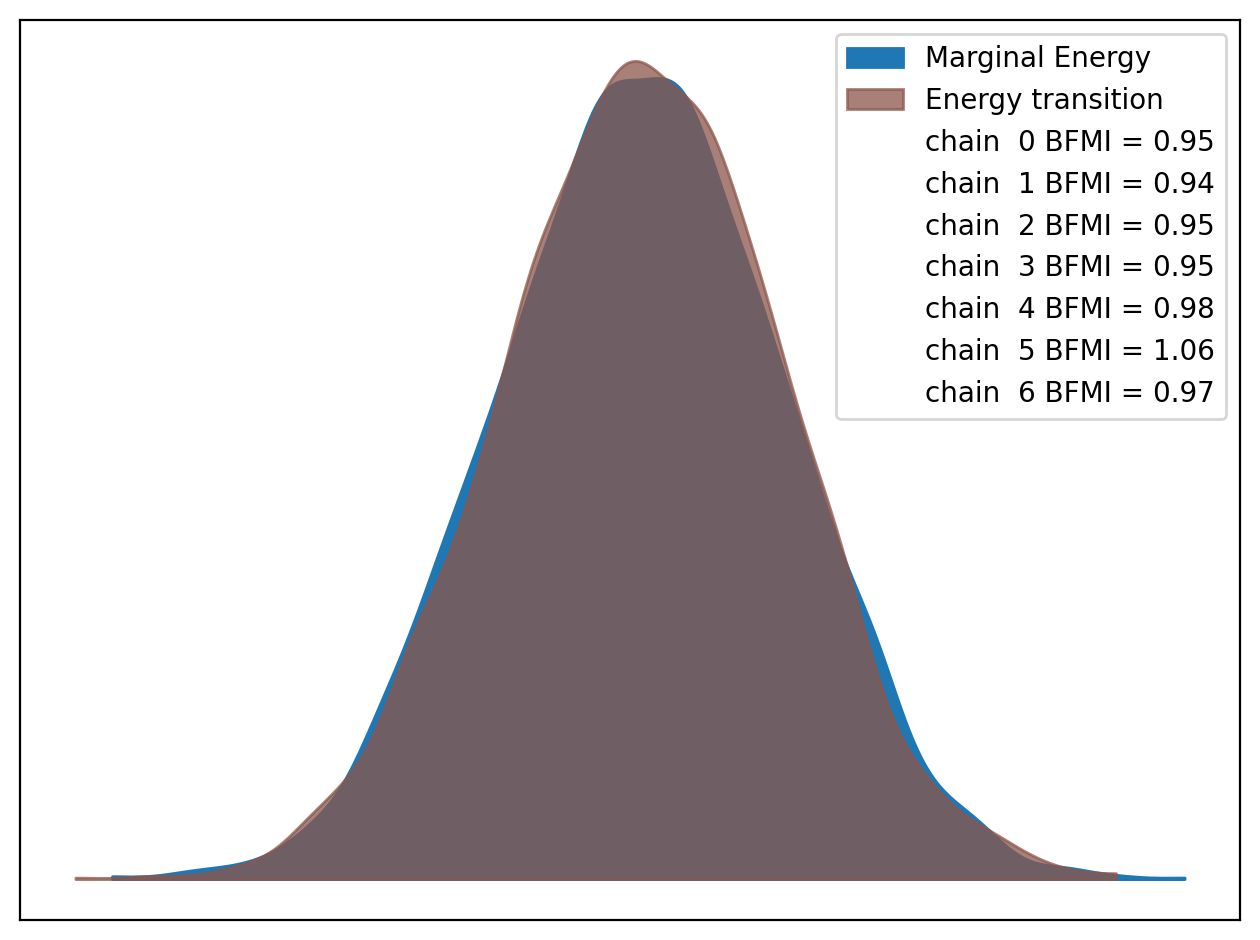

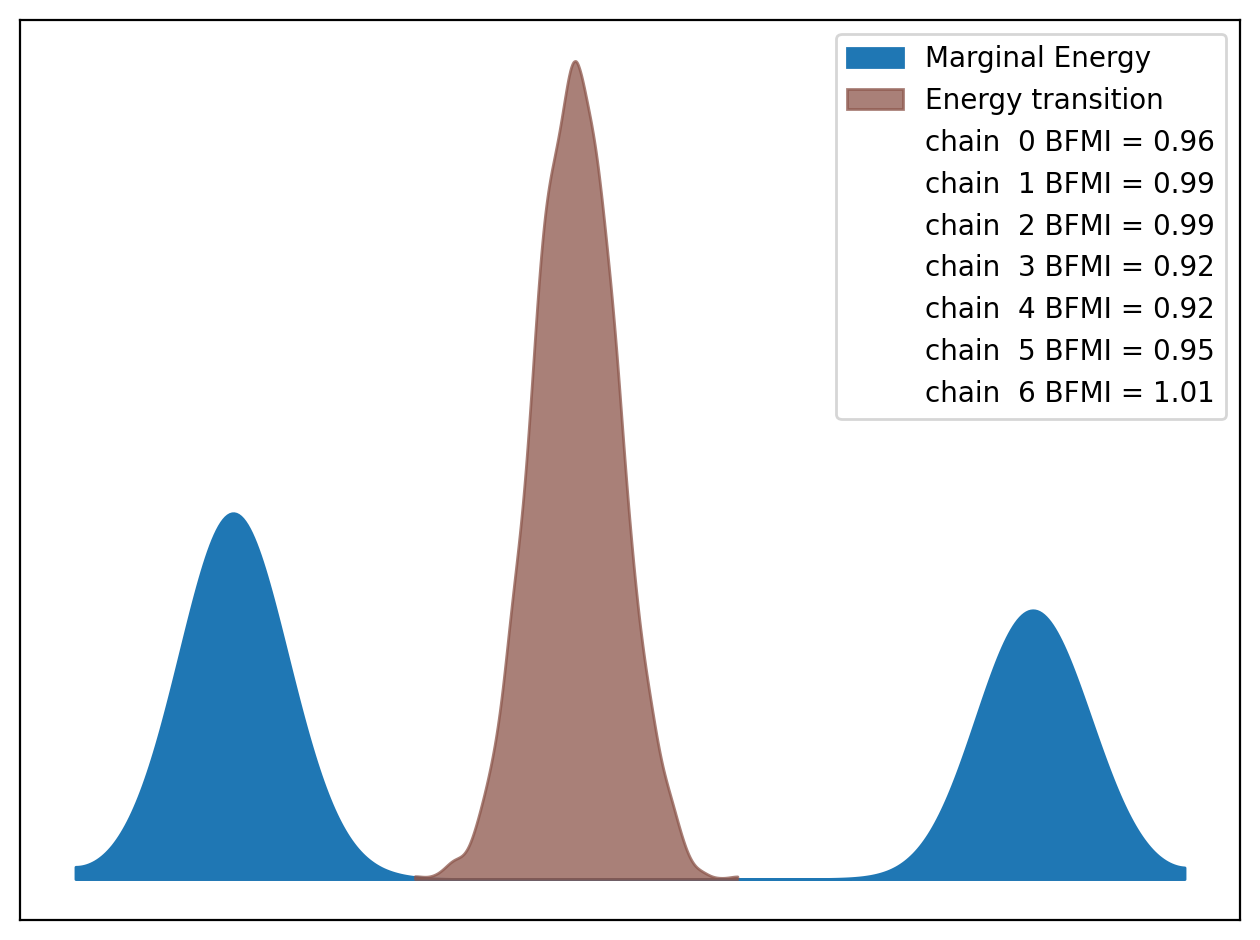

In [14]:
az.plot_trace(traces['10kb.X'], var_names=['mu', 'sigma', 'grw_sigma'], backend_kwargs={'layout': 'tight'}, compact=True);
az.plot_trace(traces['10kb.Y'], var_names=['mu', 'sigma', 'grw_sigma'], backend_kwargs={'layout': 'tight'}, compact=True);
az.plot_energy(traces['10kb.X'], backend_kwargs={'layout': 'tight'});
az.plot_energy(traces['10kb.Y'], backend_kwargs={'layout': 'tight'});

Model: 10kb.X, non-empty bins: 13841


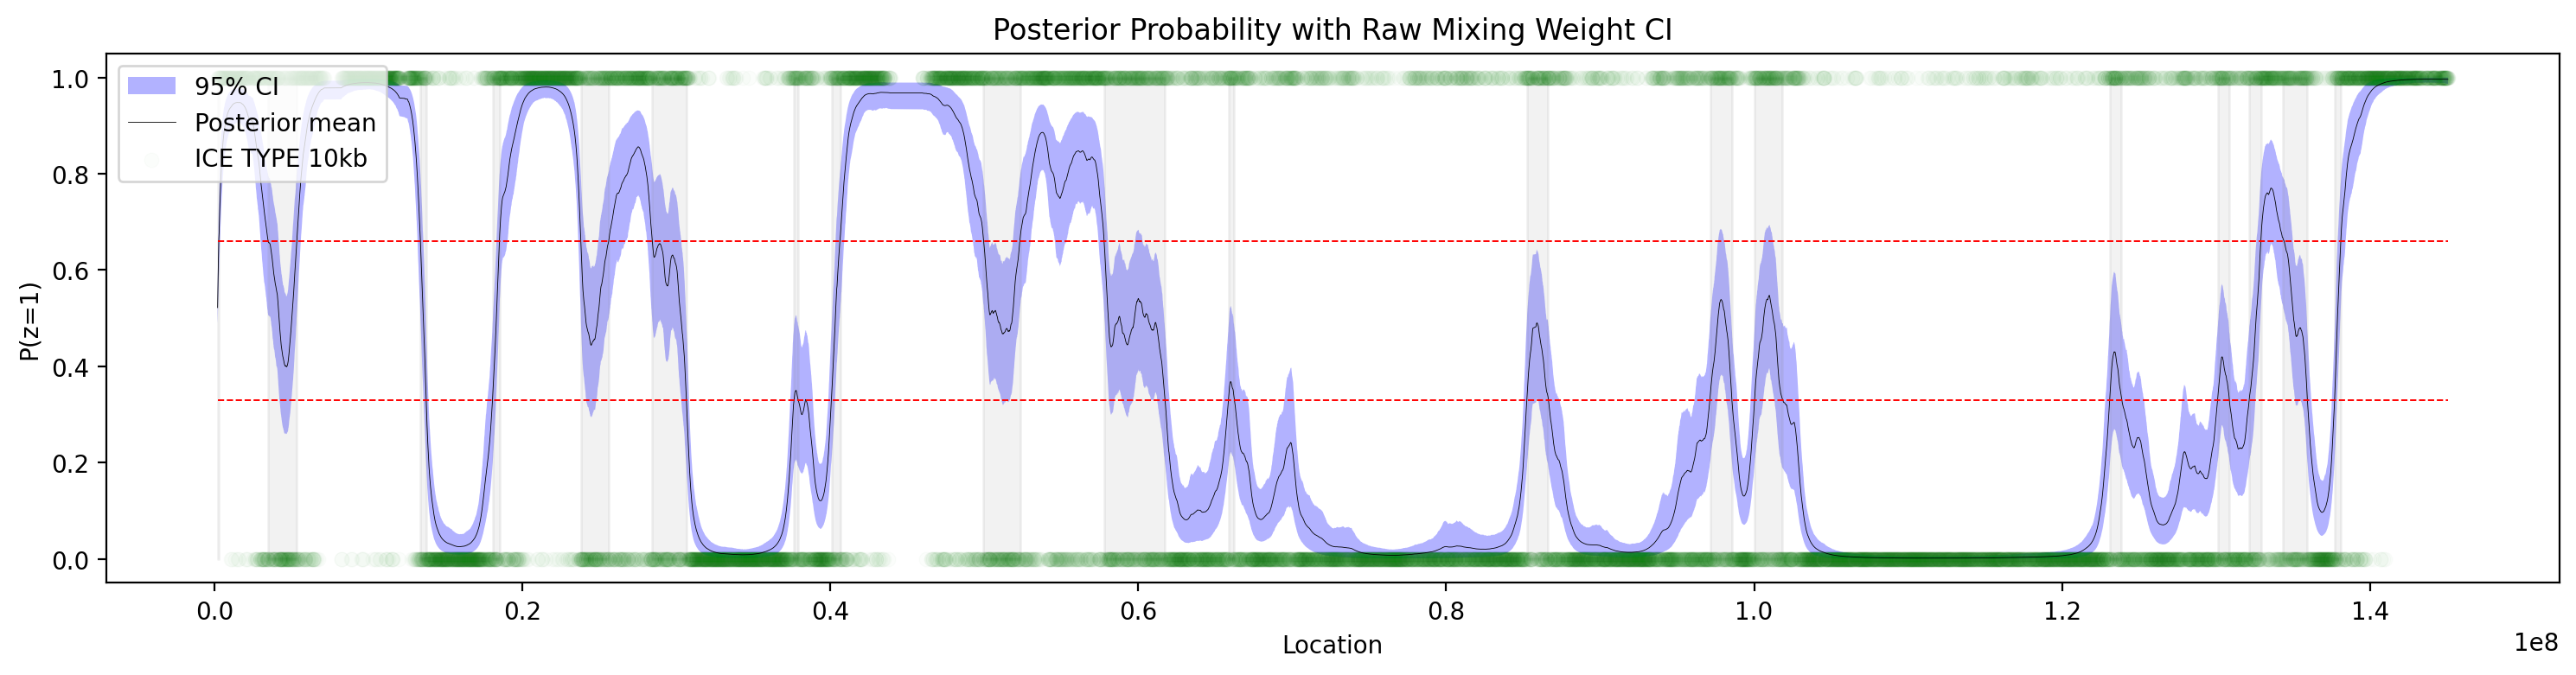

Model: 10kb.Y, non-empty bins: 13839


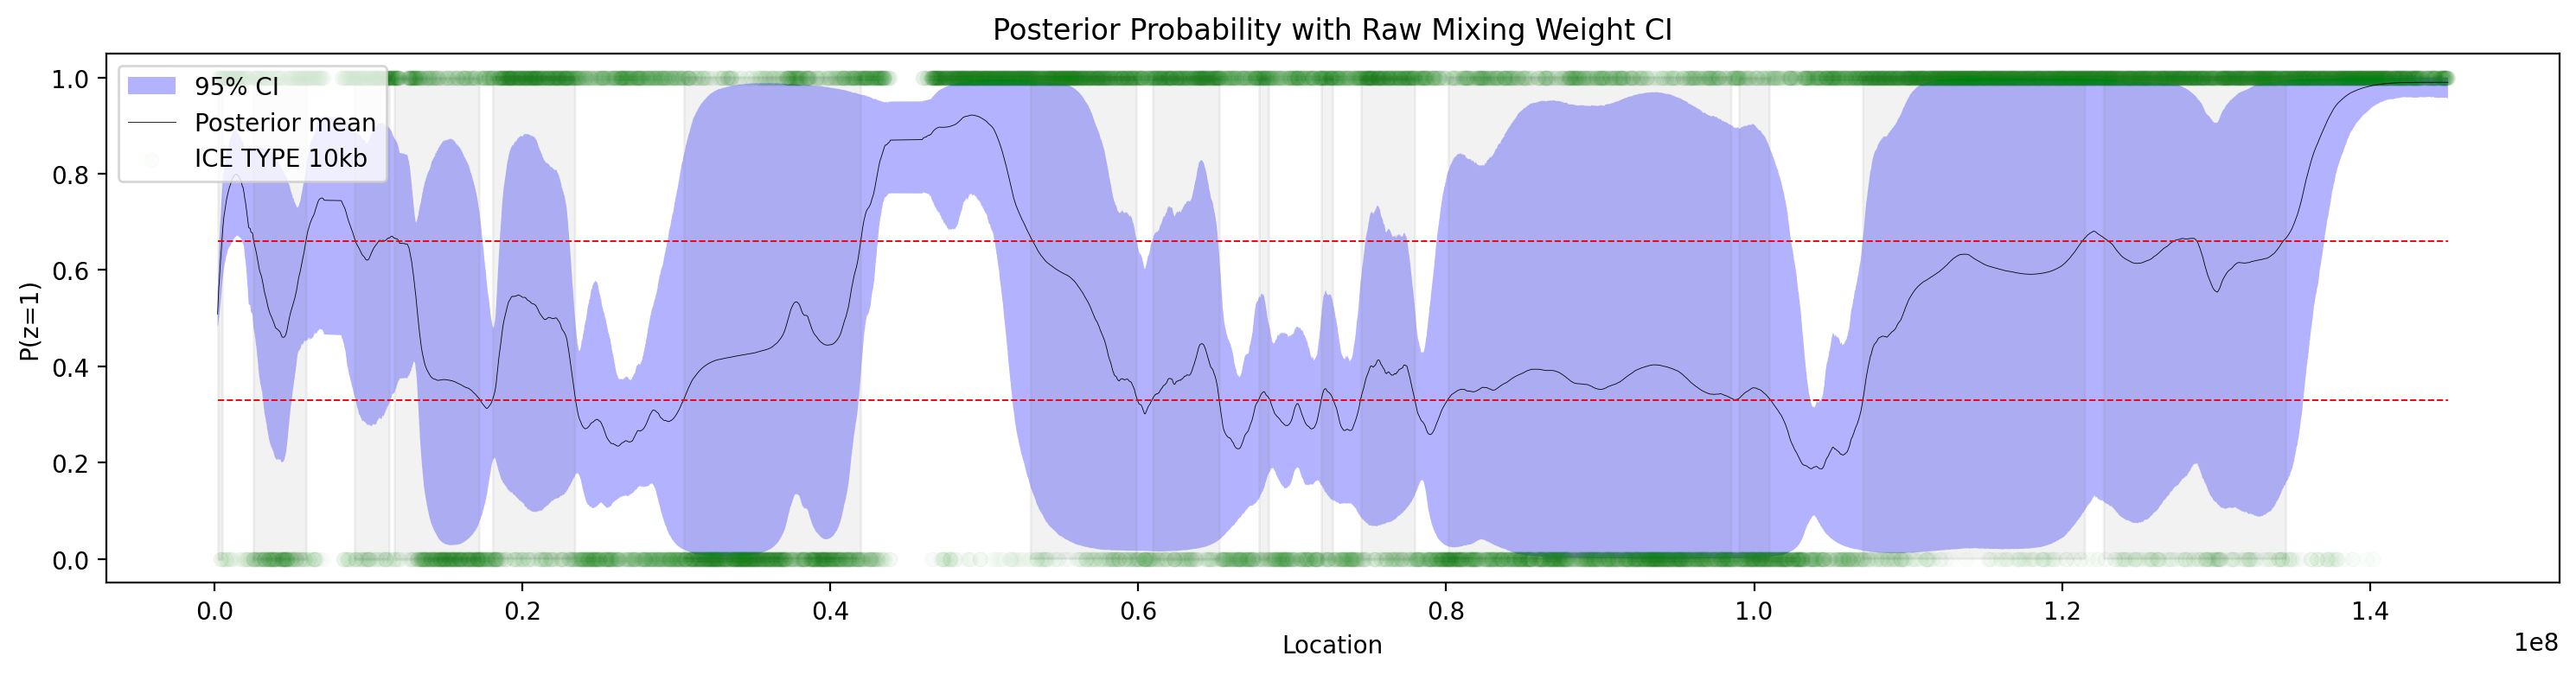

In [15]:
import matplotlib.pyplot as plt

# Set matplotlib to display retina format
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

for name, w_stack in w_vars.items():
    print(f"Model: {name}, non-empty bins: {w_stack.pos.size}")   
    w_mean = w_stack.mean(dim=('sample'))
    w_ci_direct = w_stack.quantile([0.05, 0.95], dim=("sample"))
    w_ci_upper_direct = w_ci_direct.sel(quantile=0.05)
    w_ci_lower_direct = w_ci_direct.sel(quantile=0.95)

    x = w_stack["pos"]

    f, ax = plt.subplots(figsize=(15, 4))

    ax.fill_between(
        x,
        w_ci_lower_direct,
        w_ci_upper_direct,
        alpha=0.3,
        label="95% CI",
        color="blue",
        ec='None'
    )

    x_grey = x.copy()
    x_grey = x_grey.where(
        ~((w_mean < 1/3) | (w_mean > 2/3)),
        np.nan
    )

    # Grey band
    ax.fill_between(
        x, 
        0,
        1,
        where=x_grey.notnull(),
        alpha=0.1,
        color='gray')

    # # Compare e1 predictions
    e1 = traces[name].observed_data.y_hat.values
    hard_assign =  e1 > 0

    ax.plot(x, w_mean, label="Posterior mean", color="black", linewidth=0.3)

    ax.scatter(x, hard_assign, label="ICE TYPE 10kb", color="green", linewidth=0.5, alpha=0.015)

    # Plot the 0.5 line
    ax.hlines([0.66, 0.33], min(x), max(x), color="red", linestyle="--", linewidth=0.7)

    plt.ylabel("P(z=1)")
    plt.xlabel("Location")
    plt.legend(loc='upper left')
    plt.title("Posterior Probability with Raw Mixing Weight CI")
    plt.tight_layout()
    plt.show()

    # zooms = [(10_000_000,19_000_000), (34_000_000, 48_000_000)]

    # f, axs = plt.subplots(len(zooms), figsize=(10, 3*len(zooms)))

    # for i, zoom in enumerate(zooms):
    #     zax = axs[i]
    #     zax.fill_between(
    #         x,
    #         w_ci_lower_direct,
    #         w_ci_upper_direct,
    #         alpha=0.3,
    #         color="blue",
    #         ec='None'
    #     )

    #     # Grey band
    #     zax.fill_between(
    #         x, 
    #         0,
    #         1,
    #         where=x_grey.notnull(),
    #         alpha=0.1,
    #     color='gray')

    #     zax.plot(x, w_mean, label="Posterior mean", color="black", linewidth=0.3)
    #     zax.hlines([0.66, 0.33], min(x), max(x), color="red", linestyle="--", linewidth=0.3)
    #     zax.set_xlim(zoom)
    #     zax.set_title(f"Zoomed In: {zoom}")

    # plt.tight_layout()
    # plt.show()




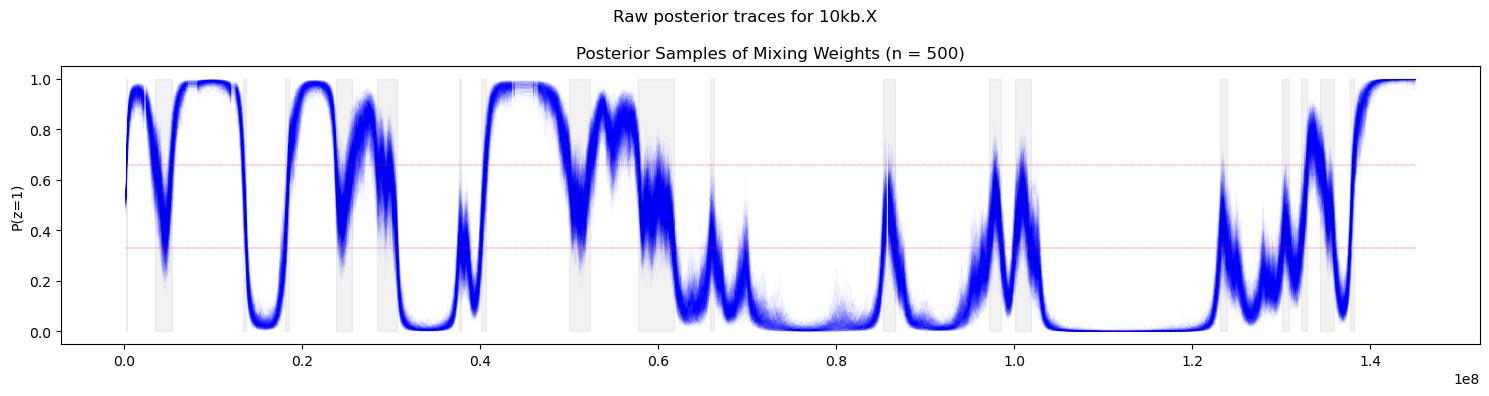

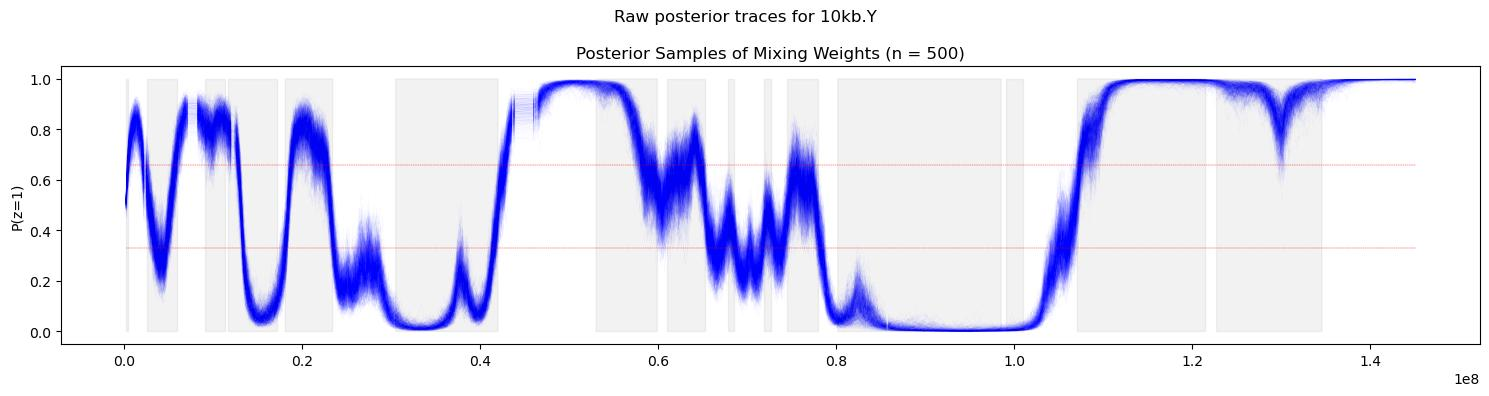

In [16]:
# Plot the all posterior samples of `w` in a single plot
# but start out with a smaller subset
# set the inline display to low dpi
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('jpg')

for name, w_stack in w_vars.items():
    x = w_stack["pos"]
    w_mean = w_stack.mean(dim=('sample'))
    w_subset = w_stack.isel(sample=slice(0, 500))  # Adjust the slice as needed

    f, ax = plt.subplots(figsize=(15, 4))

    plt.suptitle(f"Raw posterior traces for {name}")

    for i in range(w_subset.shape[1]):
        ax.plot(x, w_subset[:,i], alpha=0.1, linewidth=0.05, color="blue")

    # Grey band

    x_grey = x.where(
        ~((w_mean < 1/3) | (w_mean > 2/3)),
        np.nan
    )

    ax.fill_between(
        x, 
        0,
        1,
        where=x_grey.notnull(),
        alpha=0.1,
        color='gray')

    ax.hlines([0.66, 0.33], min(x), max(x), color="red", linestyle="--", linewidth=0.3)
    ax.set_ylabel("P(z=1)")

    plt.title(f"Posterior Samples of Mixing Weights (n = {w_subset.shape[1]})")
    plt.tight_layout()
    plt.show()


Processing model: 10kb.X


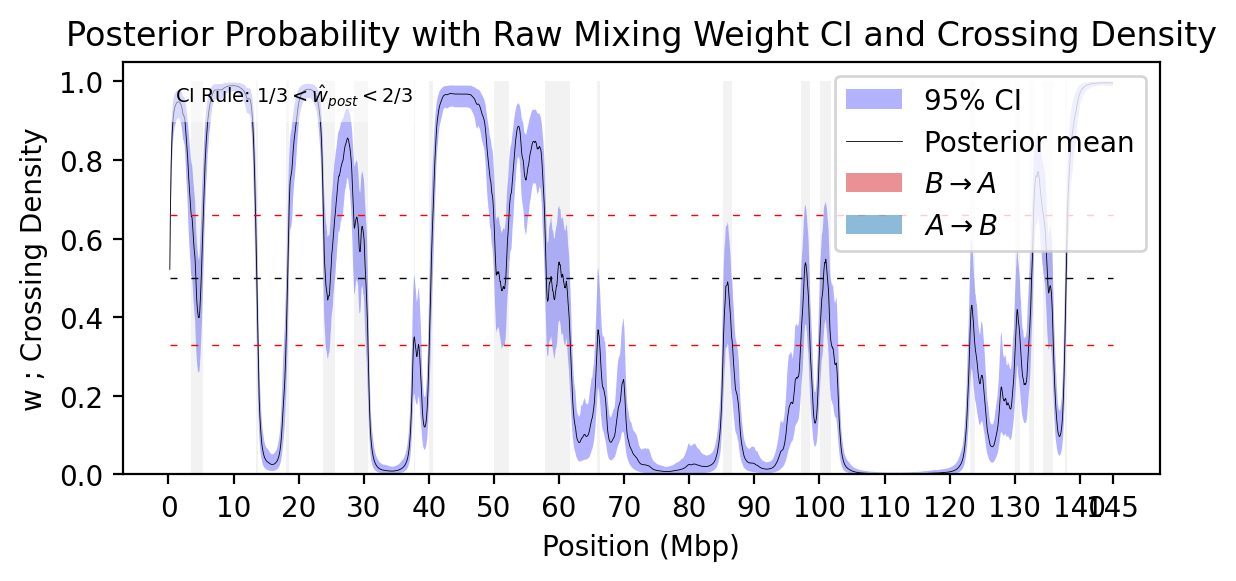

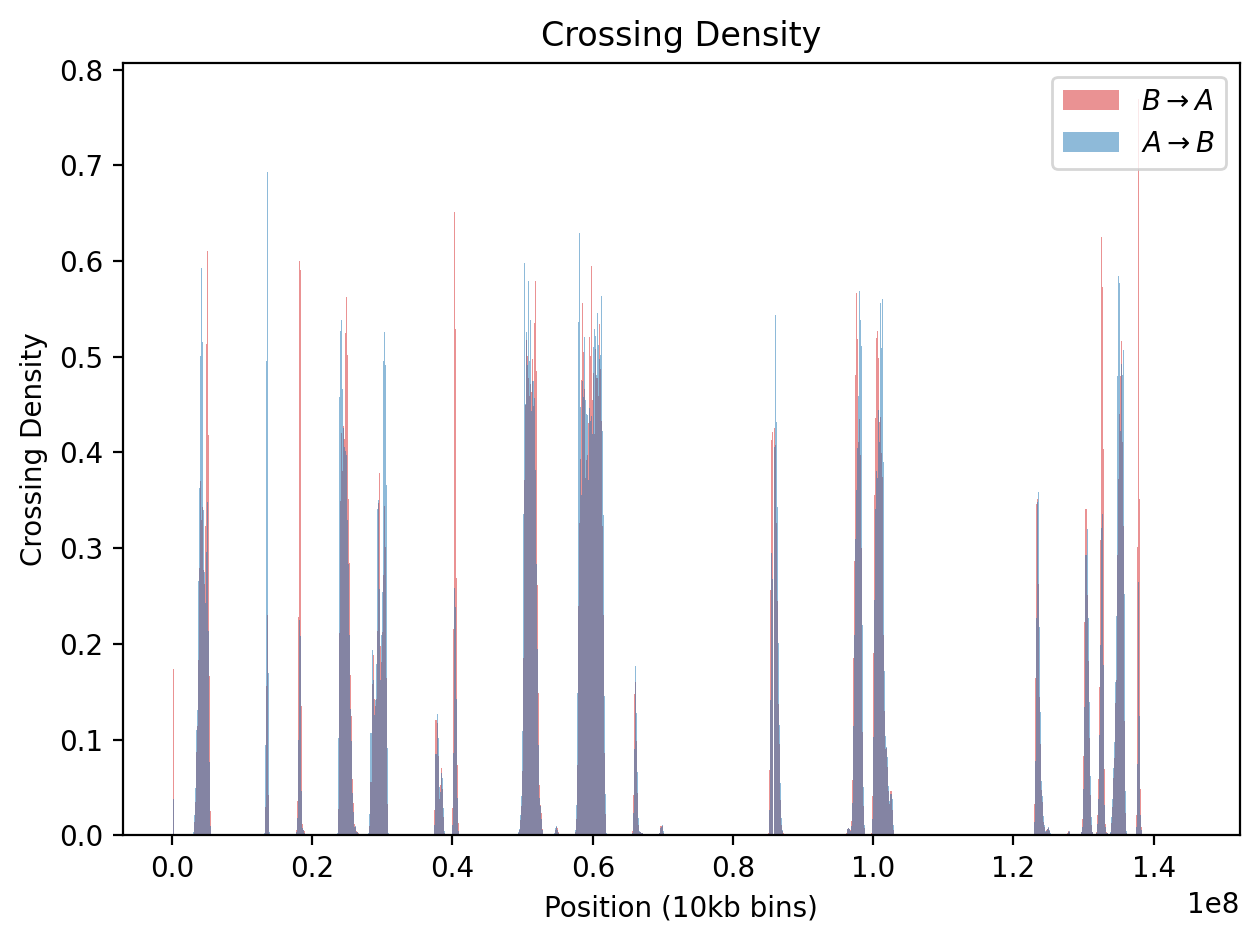

Processing model: 10kb.Y


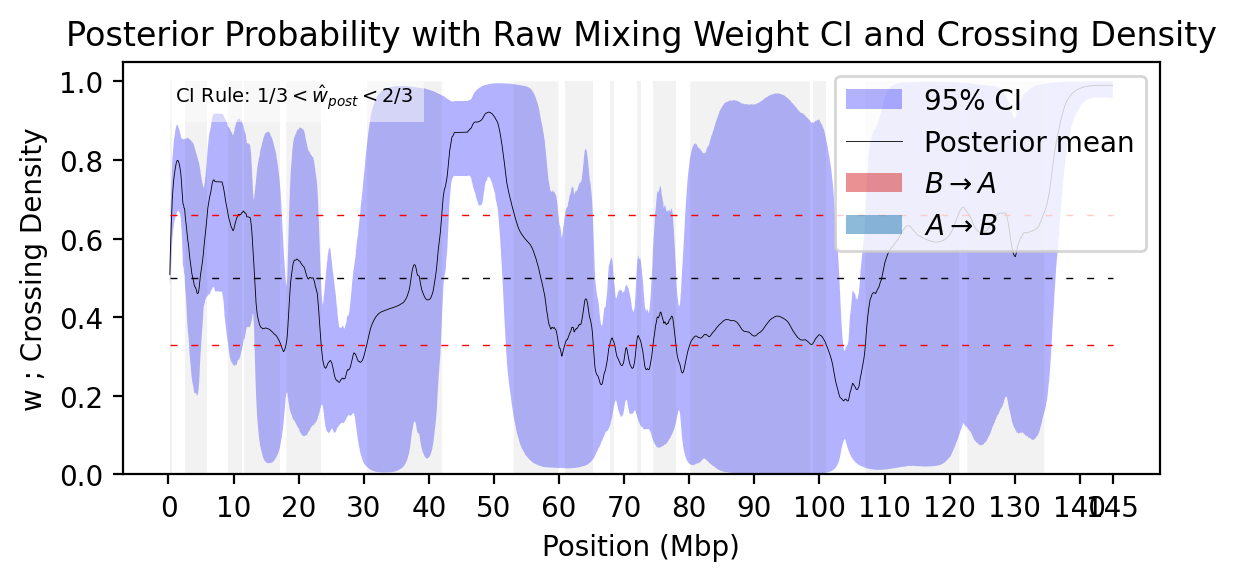

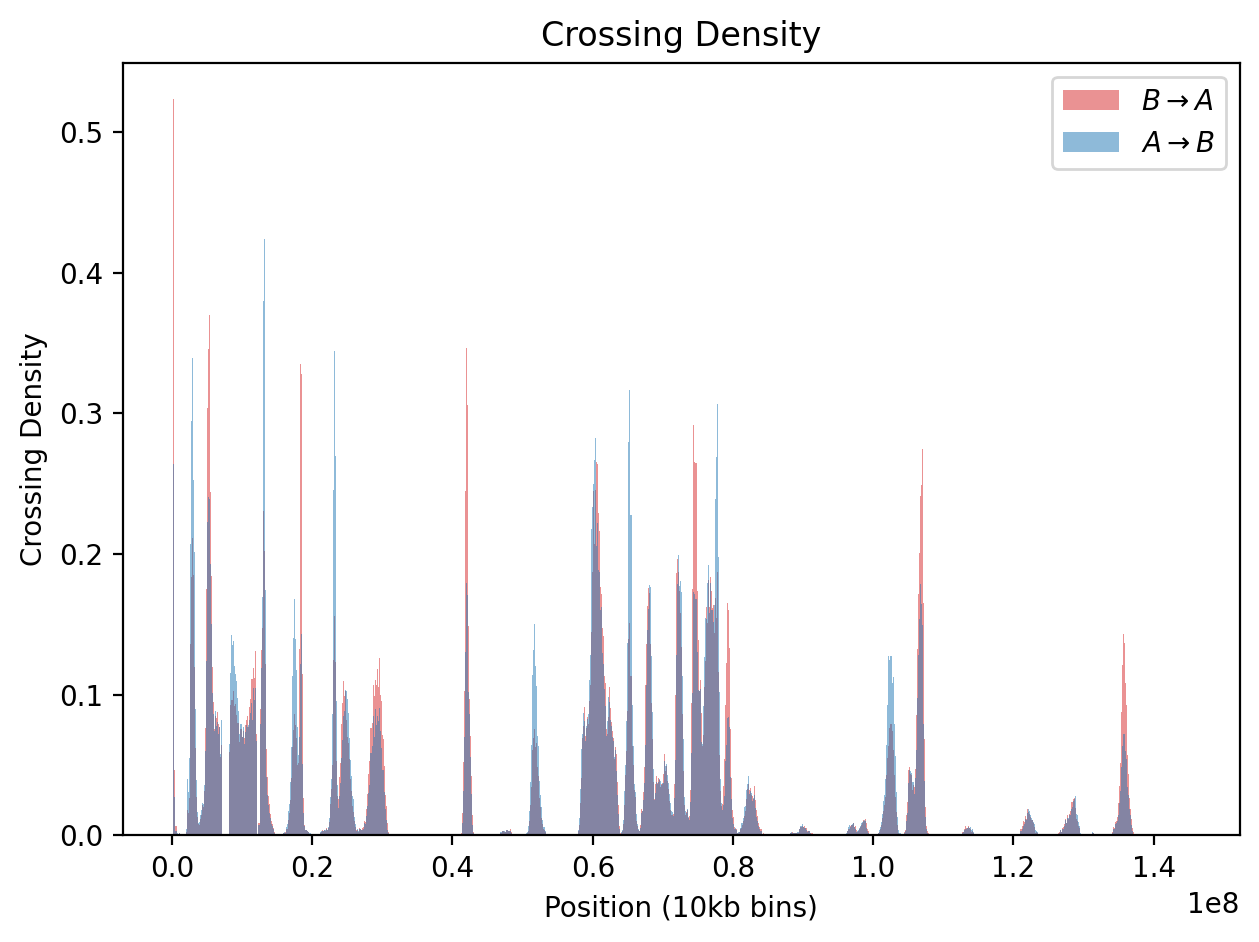

In [17]:
# Positional uncertainty based on counts
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import pandas as pd


for name, w_stack in w_vars.items():

    print("Processing model:", name)

    w_mean = w_stack.mean(dim=('sample'))
    w_ci_direct = w_stack.quantile([0.05, 0.95], dim=("sample"))
    w_ci_upper_direct = w_ci_direct.sel(quantile=0.05)
    w_ci_lower_direct = w_ci_direct.sel(quantile=0.95)

    w_np = w_stack.values  # Convert to numpy array
    w_da = w_stack # Use the xarray DataArray directly

    # Set indices for w_np
    w_idx = w_da['pos'].values

    mask = (w_np > 0.5)  # plain ndarray
    mask_next = np.roll(mask, shift=-1, axis=0)  # Shift mask down by one position
    mask_curr = mask[:, :]

    # print(f"""
    # max.w_np: {w_np.max()}
    # mask_curr.shape: {mask_curr.shape}
    #     """)

    cross_down = mask_curr & ~mask_next
    cross_up = ~mask_curr & mask_next

    # Or map the total crossings
    crossings = mask_curr != mask_next

    # Remove the last value where mask_next is wrapped from the first value
    cross_down = cross_down[:-1, :]  # Remove the last row
    cross_up = cross_up[:-1, :]  # Remove the last row
    crossings = crossings[:-1, :]  # Remove the last row

    # Sum the crossings across all samples to get the count of crossings at each position
    crossing_counts = crossings.sum(axis=1)  # Sum across the sample dimension
    cross_up_counts = cross_up.sum(axis=1)  # Sum across the sample dimension
    cross_down_counts = cross_down.sum(axis=1)  # Sum across the sample dimension


    # Calculate the density of crossings
    crossing_density = crossing_counts / w_np.shape[1]
    crossing_density_up = cross_up_counts / w_np.shape[1]
    crossing_density_down = cross_down_counts / w_np.shape[1]

    # # Print shapes of all
    # print("Shape of w_np, mask:", w_np.shape)
    # print("Shape of crossing_counts:", crossing_counts.shape)
    # print("Shape of crossing_density:", crossing_density.shape)
    # print("Shape of crossing_density_up:", crossing_density_up.shape)
    # print("Shape of crossing_density_down:", crossing_density_down.shape)

    df_crossing_density = pd.DataFrame({
        "bin": w_da["pos"].values[:-1],
        "crossing_prop_up": crossing_density_up,
        "crossing_prop_down": crossing_density_down
    })
    df_crossing_density.set_index("bin", inplace=True)
    df_crossing_density
    #df_crossing_density.to_csv("../data/compartment_transitions.10kb.human_sperm_X.tsv", sep="\t")

    x = w_stack["pos"]

    f, ax = plt.subplots(figsize=(6, 3))

    ax.fill_between(
        x,
        w_ci_lower_direct,
        w_ci_upper_direct,
        alpha=0.3,
        label="95% CI",
        color="blue",
        ec='None'
    )

    x_grey = x.copy()
    x_grey = x_grey.where(
        ~((w_mean < 1/3) | (w_mean > 2/3)),
        np.nan
    )

    # Add the CI rule
    ax.text(0.05, 0.95, "CI Rule: $1/3 < \\hat{w}_{post} < 2/3$", 
            transform=ax.transAxes, 
            fontsize=7, 
            verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Grey band
    ax.fill_between(
        x, 
        0,
        1,
        where=x_grey.notnull(),
        alpha=0.1,
        color='gray',
        ec='None'
        )

    # Plot the posterior mean
    ax.plot(x, w_mean, label="Posterior mean", color="black", linewidth=0.3)

    # Plot the 0.5 line
    ax.hlines(0.5, min(x), max(x), color="black", linestyle=(0, (5, 10)), linewidth=0.5)

    # # Plot the CI rules
    ax.hlines([0.33,0.66], min(x), max(x), color="red", linestyle=(0, (5, 10)), linewidth=0.5)

    # Plot the crossing counts
    ax.bar(x[:-1], crossing_density_up, label="$B \\rightarrow A$", color="tab:red", linewidth=0.3, alpha=0.5)
    ax.bar(x[:-1], crossing_density_down, label="$A \\rightarrow B$", color="tab:blue", linewidth=0.3, alpha=0.5)

    #  make x-axis tick x 10000*1e-6 
    ticks = np.arange(0, np.max(x), step=10_000_000)
    ticks = np.concatenate([ticks,[np.max(x)-1]])  # Ensure the last tick is included
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{int(tick*1e-6)}" for tick in ticks])

    plt.ylabel("w ; Crossing Density")
    plt.xlabel("Position (Mbp)")
    plt.legend(loc='upper right')
    plt.title("Posterior Probability with Raw Mixing Weight CI and Crossing Density")
    plt.tight_layout()
    plt.show()

    f,ax = plt.subplots()
    ax.hist(df_crossing_density.index,
            weights=df_crossing_density.crossing_prop_up, bins=1000,
            label="$B \\rightarrow A$", color="tab:red", linewidth=0.3, alpha=0.5)
    ax.hist(df_crossing_density.index, 
            weights=df_crossing_density.crossing_prop_down, bins=1000,
            label="$A \\rightarrow B$", color="tab:blue", linewidth=0.3, alpha=0.5)
    ax.set_xlabel("Position (10kb bins)")
    ax.set_ylabel("Crossing Density")
    ax.set_title("Crossing Density")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()